## Introduction

In this notebook, we will use [`pandas`](https://pandas.pydata.org/) and [`tsfresh`](https://tsfresh.readthedocs.io/) to extract features from the time series data for one of the regions. 

Later, you'll use these functions when setting up a pipeline to compare feature extraction and modeling methods against the baseline from the previous notebook.

In [1]:
%env POSTGRES_ROLE=pjm-owner

env: POSTGRES_ROLE=pjm-owner


In [2]:
%env POSTGRES_PASSWORD=LIojxdaS0AD2

env: POSTGRES_PASSWORD=LIojxdaS0AD2


In [3]:
%env POSTGRES_URL=ep-bitter-unit-a57lkric.us-east-2.aws.neon.tech

env: POSTGRES_URL=ep-bitter-unit-a57lkric.us-east-2.aws.neon.tech


In [4]:
%env POSTGRES_DATABASE_NAME=pjm-energy-consumption

env: POSTGRES_DATABASE_NAME=pjm-energy-consumption


### Goal: Pluggable Feature Encoders

The total dataset from 2004-2018 has ~1M time series data points across 11 regions. In the last notebook, we used the `get_ts_features` function to load the data into a pandas DataFrame and crafted training features for one region by flattening the timestamp column into several features.

The objective of this notebook is to create two more functions that add more columns to the dataframe containing new features. Specifically, we'll add:
1. **Basic Averaging Time Series Features** in `get_ts_averages_features`
2. **Advanced Time Series Features** in `compute_lookback_features`

> 💡 These functions should be able to ingest inference data and training data in the same way. If the feature encoders are parameterized, parameters should only be learned based on training data.



In [5]:
### Notebook setup
from pprint import pprint
import pandas as pd
import numpy as np
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

In [6]:
from data_ingestion import load_merged_data

In [7]:
df = load_merged_data()

In [8]:
df.describe()

AEP_MW      COMED_MW     DAYTON_MW       DEOK_MW        DOM_MW  \
count  89928.000000  35136.000000  89928.000000  26376.000000  84840.000000   
mean   15741.109677  11560.947774   2047.798194   3094.786510  10851.056884   
std     2572.638805   2356.119533    397.639911    588.652699   2367.799566   
min     9669.000000   7237.000000    982.000000   1870.000000   1253.000000   
25%    13895.000000   9897.000000   1757.000000   2686.000000   9265.000000   
50%    15565.000000  11315.500000   2022.000000   3019.000000  10434.000000   
75%    17411.000000  12651.000000   2291.000000   3428.000000  12260.000000   
max    25695.000000  23753.000000   3746.000000   5445.000000  20588.000000   

             DUQ_MW       EKPC_MW         FE_MW         NI_MW        PJME_MW  \
count  87720.000000  13968.000000  31512.000000  58464.000000  114024.000000   
mean    1682.361947   1469.398053   7836.046236  11701.084189   32287.329422   
std      297.709403    383.159335   1338.493261   2371.594565    6451.112572   
min     1049.000000    514.000000      0.000000   7003.000000   14544.000000   
25%     1470.000000   1186.000000   6836.000000   9953.000000   27787.000000   
50%     1659.000000   1400.000000   7771.000000  11520.000000   31697.500000   
75%     1837.000000   1710.000000   8617.250000  12896.000000   35791.000000   
max     3054.000000   3425.000000  14032.000000  23631.000000   62009.000000   

             PJMW_MW  
count  111864.000000  
mean     5599.664226  
std       964.583101  
min       487.000000  
25%      4915.000000  
50%      5547.000000  
75%      6247.000000  
max      9349.000000

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114024 entries, 2002-01-01 01:00:00 to 2015-01-03 21:00:00
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   AEP_MW     89928 non-null   float64
 1   COMED_MW   35136 non-null   float64
 2   DAYTON_MW  89928 non-null   float64
 3   DEOK_MW    26376 non-null   float64
 4   DOM_MW     84840 non-null   float64
 5   DUQ_MW     87720 non-null   float64
 6   EKPC_MW    13968 non-null   float64
 7   FE_MW      31512 non-null   float64
 8   NI_MW      58464 non-null   float64
 9   PJME_MW    114024 non-null  float64
 10  PJMW_MW    111864 non-null  float64
dtypes: float64(11)
memory usage: 10.4 MB


### Generic Averaging Time Series Features
Let's add some basic assertions to validate the contents of our basic averaging time series features.



### Feature Encoder 1: Moving averages
In this section, we'll filter to a year for one region and compute the statistics related to moving averages.
Later, we'll merge these features to the `x_train` dataframe.

In [10]:
%%writefile -a ts_feature_encoders.py
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from tsfresh import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.utilities.distribution import MultiprocessingDistributor
from concurrent.futures import ThreadPoolExecutor, as_completed


def get_ts_averages_features(df, drop_columns=[]):
    """
    Compute generic time series statistics for a given dataframe.

    Parameters:
    df (pd.DataFrame): Input dataframe with 'Datetime' and 'value' columns.

    Returns:
    pd.DataFrame: Dataframe with computed statistics.
    """
    df = df.sort_values("Datetime")
    df = df[~df.index.duplicated()]
    df["MA_7d"] = df["value"].rolling(window=24 * 7).mean()
    df["MA_30d"] = df["value"].rolling(window=24 * 30).mean()
    df["EMA_7d"] = df["value"].ewm(span=24 * 7).mean()
    df["EMA_30d"] = df["value"].ewm(span=24 * 30).mean()
    df["rolling_std_7d"] = df["value"].rolling(window=24 * 7).std()
    df["rolling_max_30d"] = df["value"].rolling(window=24 * 30).max()
    df["rolling_min_30d"] = df["value"].rolling(window=24 * 30).min()
    df["pct_change"] = df["value"].pct_change(fill_method=None)
    df["rate_of_change_7d"] = (df["value"] - df["value"].shift(7)) / df["value"].shift(
        7
    )
    if drop_columns:
        df.drop(columns=['Datetime', 'id', 'value'], inplace=True)
    return df


def compute_lookback_window(df, lookback_days=30, max_workers=None):
    """
    Compute "lookback window" for a time series dataframe.

    Parameters:
    df (pd.DataFrame): Input dataframe with 'Datetime' and 'value' columns.
    lookback_days (int): Number of days to look back for features.
    max_workers (int): Maximum number of workers for parallel processing.

    Returns:
    pd.DataFrame: Dataframe with computed lookback features.
    """
    df = df.sort_values("Datetime")
    result_list = []
    from tqdm import tqdm
    for i in tqdm(range(1, 24 * lookback_days), desc="Processing lookback days"):
        shifted_df = df.shift(i)[i:].reset_index().drop(columns=['id']).rename(columns={'index': 'id'})
        result_list.append(shifted_df)
    result_df = pd.concat(result_list)
    result_df.id = result_df.id.astype(int)
    return result_df

Appending to ts_feature_encoders.py


In [11]:
start_year = 2005
end_year = 2006
region = 'AEP_MW'

# df.Datetime = pd.to_datetime(df.Datetime)
df_year = df[[region]][
    (df.index >= pd.Timestamp(f"{start_year}-01-01")) & 
    (df.index < pd.Timestamp(f"{end_year}-01-01"))
]
df_year['id'] = region
df_year.rename(columns={region: 'value'}, inplace=True)
df_year

value      id
Datetime                            
2005-01-01 00:00:00  12892.0  AEP_MW
2005-01-01 01:00:00  12316.0  AEP_MW
2005-01-01 02:00:00  11890.0  AEP_MW
2005-01-01 03:00:00  11579.0  AEP_MW
2005-01-01 04:00:00  11461.0  AEP_MW
...                      ...     ...
2005-12-31 19:00:00  16462.0  AEP_MW
2005-12-31 20:00:00  16024.0  AEP_MW
2005-12-31 21:00:00  15722.0  AEP_MW
2005-12-31 22:00:00  15264.0  AEP_MW
2005-12-31 23:00:00  14921.0  AEP_MW

[8760 rows x 2 columns]

In [12]:
from ts_feature_encoders import get_ts_averages_features

In [13]:
# Compute "Basic Averaging Time Series Features" features
feats = get_ts_averages_features(df_year)

In [14]:
import unittest
import pandas as pd
import numpy as np
from io import StringIO

class TestGenericAveragingTsFeatures(unittest.TestCase):

    def setUp(self):
        dates = pd.date_range(start='2023-01-01', end='2023-02-01')
        self.df = pd.DataFrame({
            'Datetime': dates,
            'value': np.random.rand(len(dates))
        })

    def test_basic_functionality(self):
        result = get_ts_averages_features(self.df)
        expected_columns = ['Datetime', 'value', 'MA_7d', 'MA_30d', 'EMA_7d', 'EMA_30d', 
                            'rolling_std_7d', 'rolling_max_30d', 'rolling_min_30d', 
                            'pct_change', 'rate_of_change_7d']
        self.assertTrue(all(col in result.columns for col in expected_columns))

    def test_null_values(self):
        self.df.loc[10:20, 'value'] = None
        result = get_ts_averages_features(self.df)
        self.assertTrue(result['MA_7d'].isnull().any())
        self.assertTrue(result['MA_30d'].isnull().any())
        self.assertTrue(result['pct_change'].isnull().any())

    def test_constant_values(self):
        self.df['value'] = 1.0
        result = get_ts_averages_features(self.df)
        self.assertTrue((result['pct_change'][1:] == 0).all())
        self.assertTrue((result['rate_of_change_7d'][7:] == 0).all())

    def test_empty_dataframe(self):
        empty_df = pd.DataFrame(columns=['Datetime', 'value'])
        result = get_ts_averages_features(empty_df)
        self.assertTrue(result.empty)

suite = unittest.TestLoader().loadTestsFromTestCase(TestGenericAveragingTsFeatures)
output = StringIO()
runner = unittest.TextTestRunner(stream=output, verbosity=2)
result = runner.run(suite)

print(output.getvalue())
print(f"Ran {result.testsRun} tests")
print(f"Successes: {result.testsRun - len(result.failures) - len(result.errors)}")
print(f"Failures: {len(result.failures)}")
print(f"Errors: {len(result.errors)}")

test_basic_functionality (__main__.TestGenericAveragingTsFeatures.test_basic_functionality) ... ok
test_constant_values (__main__.TestGenericAveragingTsFeatures.test_constant_values) ... ok
test_empty_dataframe (__main__.TestGenericAveragingTsFeatures.test_empty_dataframe) ... ok
test_null_values (__main__.TestGenericAveragingTsFeatures.test_null_values) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.019s

OK

Ran 4 tests
Successes: 4
Failures: 0
Errors: 0


In [15]:
%%writefile -a visualization.py

TS_COLS = [
    'Original Frequency', 
    '7-day MA', '30-day MA', 
    '7-day EMA', '30-day EMA',
    '7-day Rolling Std', '30-day Rolling Max', '30-day Rolling Min',
]

def reshape_ts_features_for_altair(feats):
    raw_data = feats[['id', 'value']].copy()
    raw_data['type'] = 'Original Frequency'
    ma_7d = feats[['id', 'MA_7d']].rename(columns={'MA_7d': 'value'})
    ma_7d['type'] = '7-day MA'
    ma_30d = feats[['id', 'MA_30d']].rename(columns={'MA_30d': 'value'})
    ma_30d['type'] = '30-day MA'
    ema_7d = feats[['id', 'EMA_7d']].rename(columns={'EMA_7d': 'value'})
    ema_7d['type'] = '7-day EMA'
    ema_30d = feats[['id', 'EMA_30d']].rename(columns={'EMA_30d': 'value'})
    ema_30d['type'] = '30-day EMA'
    rolling_std_7d = feats[['id', 'rolling_std_7d']].rename(columns={'rolling_std_7d': 'value'})
    rolling_std_7d['type'] = '7-day Rolling Std'
    rolling_max_30d = feats[['id', 'rolling_max_30d']].rename(columns={'rolling_max_30d': 'value'})
    rolling_max_30d['type'] = '30-day Rolling Max'
    rolling_min_30d = feats[['id', 'rolling_min_30d']].rename(columns={'rolling_min_30d': 'value'})
    rolling_min_30d['type'] = '30-day Rolling Min'
    plot_data = pd.concat([
        raw_data,
        ma_7d, ma_30d, 
        ema_7d, ema_30d, 
        rolling_std_7d,
        rolling_max_30d, rolling_min_30d
    ])
    return plot_data

def create_layered_chart(plot_data, measures, title):
    colors = [GREY_COLOR]
    colors.extend(generate_random_colors_hex(len(TS_COLS)-1, palette='coolwarm'))
    color_scale = alt.Scale(
        domain=TS_COLS,
        range=colors
    )
    base = alt.Chart(plot_data).encode(
        x=alt.X('Datetime:T', title='Date'),
        tooltip=['Datetime:T', 'value:Q', 'type:N']
    ).properties(
        width=800,
        height=200
    )
    original = base.transform_filter(
        alt.FieldEqualPredicate(field='type', equal='Original Frequency')
    ).mark_line(opacity=0.5).encode(
        y=alt.Y('value:Q', title='Value'),
        color= alt.value(GREY_COLOR)
    )
    layers = [original]
    for measure in measures:
        layer = base.transform_filter(
            alt.FieldEqualPredicate(field='type', equal=measure)
        ).mark_line().encode(
            y='value:Q',
            color=alt.Color('type:N', scale=color_scale)
        )
        layers.append(layer)
    
    return alt.layer(*layers).properties(title=title)

def plot_cv_results(x_train, y_train, x_valid, y_valid, y_valid_pred, region):

    fold_plot_df = join_data_alt(
        x_train,
        y_train,
        x_valid,
        y_valid,
        y_valid_pred,
        region
    )
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
    train_df = fold_plot_df[fold_plot_df["type"] == "train"].copy()
    valid_df = fold_plot_df[fold_plot_df["type"] == "actual"].copy()
    pred_df = fold_plot_df[fold_plot_df["type"] == "prediction"].copy()

    for df in [train_df, valid_df, pred_df]:
        if region in df.columns:
            df.rename(columns={region: 'value'}, inplace=True)

    valid_years = x_valid.year.unique()
    prediction_year = (
        f"{valid_years[0]}-{valid_years[-1]}"
        if len(valid_years) > 1
        else valid_years[0]
    )
    ax.plot(train_df.date, train_df['value'], alpha=0.25, color="#4C9878")
    ax.plot(valid_df.date, valid_df['value'], alpha=0.75, color="#4C9878")
    ax.plot(pred_df.date, pred_df['value'], alpha=0.75, color="#976BAC")
    ax.set_xticks([])
    ax.set_title(prediction_year)
    return fig

Appending to visualization.py


In [16]:
from visualization import (
    reshape_ts_features_for_altair,
    create_layered_chart,
    generate_random_colors_hex,
    FOREGROUND_COLOR,
    BACKGROUND_COLOR,
    GREY_COLOR,
    TS_COLS
)
plot_data = reshape_ts_features_for_altair(feats)

In [17]:
colors = [GREY_COLOR]
colors.extend(generate_random_colors_hex(len(TS_COLS)-1, palette='coolwarm'))
color_scale = alt.Scale(
    domain=TS_COLS,
    range=colors
)

base = alt.Chart(plot_data).encode(
    x=alt.X('Datetime:T', title='Date'),
    tooltip=['Datetime:T', 'value:Q', 'type:N']
).properties(
    width=800,
    height=200
)

ma_ema_chart = create_layered_chart(plot_data, ['7-day MA', '30-day MA', '7-day EMA', '30-day EMA'], 'Moving Averages vs Original Frequency')
rolling_chart = create_layered_chart(plot_data, ['7-day Rolling Std', '30-day Rolling Max', '30-day Rolling Min'], 'Rolling Statistics vs Original Frequency')

final_chart = alt.vconcat(ma_ema_chart, rolling_chart).properties(
    title='',
    background=BACKGROUND_COLOR,
    padding={'left': 10, 'top': 10, 'right': 10, 'bottom': 10}
).resolve_scale(
    y='independent'
).configure_view(
    strokeWidth=0,
    fill=BACKGROUND_COLOR,
).configure_axis(
    labelColor=FOREGROUND_COLOR,
    titleColor=FOREGROUND_COLOR
).configure_title(
    color=BACKGROUND_COLOR,
    dy=-10
).configure_legend(
    titleColor=FOREGROUND_COLOR,
    labelColor=FOREGROUND_COLOR,
    fillColor=BACKGROUND_COLOR,
    padding=10,
    cornerRadius=10
).interactive()

final_chart

alt.VConcatChart(...)

### Feature Encoder 2: Lookback `tsfresh` Features
The `tsfresh` library provides a convenient way to extract sophisticated time series features.

We've already restructured the `df_tsfresh` dataframe, and the `df_month` sample which is a one month slice of this data. The data in the form has a `Datetime` column and an `id` column where `id` signifies each unique time series - a lookback window of `lookback_days` _for each data point_. This is a tunable parameter defined in the `compute_lookback_window` function. By default, we lookback 30 days for computing features for each data point.

In this section, we'll see the process of this feature encoder and how it changes the shape of a slice of the training data. In the next section, we'll see the feature encoder in action as the final features are fed into an XGBoost model.

In [18]:
%%writefile tsfresh_feature_encoders.py
### This code was generated by a Jupyter notebook %%writefile command in candidate_tsfresh.ipynb. ### 

import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from tsfresh import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.utilities.distribution import MultiprocessingDistributor
from concurrent.futures import ThreadPoolExecutor, as_completed
from ts_feature_encoders import get_ts_features, get_ts_averages_features
from metaflow.cards import Markdown

# https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html
DEFAULT_FC_PARAMS_INCLUDE_LS = [
    "absolute_sum_of_changes",
    "agg_autocorrelation",
    "agg_linear_trend",
    "ar_coefficient",
    "benford_correlation",
    "kurtosis",
    "skewness",
]

def get_tsfresh_fc_params(fc_params_include_ls=DEFAULT_FC_PARAMS_INCLUDE_LS):
    d = ComprehensiveFCParameters().data
    to_remove = []
    for k, v in d.items():
        if k not in fc_params_include_ls:
            to_remove.append(k)
    for k in to_remove:
        d.pop(k)
    return d


def reshape_for_tsfresh(
    df, ts_col="Datetime", id_col="id", value_col="value", var_col="region", region='AEP_MW'
):
    df.reset_index(inplace=True)  # make the Datetime column a column instead of index
    df_melted = pd.melt(df, id_vars=[ts_col], var_name=var_col, value_name=value_col)
    df_melted[id_col] = df_melted[var_col]
    df_melted[ts_col] = pd.to_datetime(df_melted[ts_col])
    df_melted = df_melted.sort_values([id_col, ts_col])
    df_melted = df_melted.dropna()
    df_tsfresh = df_melted[[id_col, ts_col, value_col]]
    df_tsfresh = df_tsfresh[df_tsfresh['id'] == region]
    df_tsfresh = df_tsfresh.reset_index(drop=True)
    return df_tsfresh

def compute_lookback_window(df, lookback_days=30, max_workers=None):
    """
    Compute "lookback window" for a time series dataframe.

    Parameters:
    df (pd.DataFrame): Input dataframe with 'Datetime' and 'value' columns.
    lookback_days (int): Number of days to look back for features.
    max_workers (int): Maximum number of workers for parallel processing.

    Returns:
    pd.DataFrame: Dataframe with computed lookback features.
    """
    result_list = []
    from tqdm import tqdm
    for i in tqdm(range(1, 24 * lookback_days), desc="Processing lookback days"):
        shifted_df = df.shift(i)[i:].reset_index().drop(columns=['id']).rename(columns={'index': 'id'})
        result_list.append(shifted_df)
    result_df = pd.concat(result_list)
    result_df.id = result_df.id.astype(int)
    return result_df

def tsfresh_extract_features(df_lookback, id_col="id", sort_col="Datetime"):
    """
    Extract features from a given dataframe containing a lookback window.
    Use this function on the output of compute_lookback_window.

    Parameters:
    df_lookback (pd.DataFrame): Input dataframe with 'Datetime' and 'value' columns.

    Returns:
    pd.DataFrame: Dataframe with computed features.
    """
    distributor = MultiprocessingDistributor(
        n_workers=os.cpu_count(),
        disable_progressbar=False,
        progressbar_title="Feature Extraction",
    )

    if df_lookback.empty:
        print("df_lookback is empty")
        return pd.DataFrame()

    return extract_features(
        df_lookback,
        column_id=id_col,
        column_sort=sort_col,
        default_fc_parameters=get_tsfresh_fc_params(),
        distributor=distributor,
    )

TSFRESH_DROP_COLS = [
    'index'
]
def create_tsfresh_features(df, lookback_days=5, current=None):

    df_ts = get_ts_features(df)

    if current is not None:
        status_msg = Markdown("Status: Computing features with time series averages.")
        current.card["xgboost_progress"].append(status_msg)
        current.card.refresh()

    df_avg = get_ts_averages_features(df)
    df_merged = df_ts.merge(
        df_avg,
        how="outer",
        on=["Datetime"],
    )

    if current is not None:
        current.card["xgboost_progress"].append(
            Markdown(f"* X.shape after ts averages: **{df_merged.shape}**")
        )
        status_msg.update("Status: Computing lookback window for tsfresh.")
        current.card["xgboost_progress"].refresh()

    df_merged.drop(columns=["id", "value"], inplace=True)
    df_lookback = compute_lookback_window(df, lookback_days=lookback_days)

    if current is not None:
        current.card["xgboost_progress"].append(
            Markdown(
                f"* df_lookback.shape for this feature chunk: **{df_lookback.shape}**"
            )
        )
        status_msg.update("Status: Running tsfresh.")
        current.card["xgboost_progress"].refresh()

    df_tsfresh = tsfresh_extract_features(df_lookback)
    df_tsfresh.reset_index(inplace=True)
    # X = df_merged.join(df_tsfresh, how='outer', on=['Datetime'])
    X = pd.concat([df_merged, df_tsfresh], axis=1)
    
    if current is not None:
        current.card["xgboost_progress"].append(
            Markdown(f"* X.shape after tsfresh: **{X.shape}**")
        )
        status_msg.update("Status: Feature computation done.")
        current.card["xgboost_progress"].refresh()

    # Some tsfresh features are returned as objects. Convert them to something XGBoost can use.
    object_columns = X.select_dtypes(include=['object']).columns
    for col in object_columns:
        X[col] = X[col].astype(np.float64)

    X.drop(columns=TSFRESH_DROP_COLS, inplace=True)
    X.set_index('Datetime', inplace=True)
    y = df.value
    y.index = X.index
    return X, y

Overwriting tsfresh_feature_encoders.py


In [19]:
from ts_feature_encoders import get_ts_averages_features
from tsfresh_feature_encoders import reshape_for_tsfresh

In [20]:
month = 2
region = 'COMED_MW'

end_ts = df[[region]][
    ~df.COMED_MW.isna()
].index.max()
start_year = end_ts.year - 1
end_year = end_ts.year

df_region = df[[region]][
    (df.index.year >= start_year) & 
    (df.index.year < end_year) & 
    (df.index.month == month)
].reset_index()
df_region

Datetime  COMED_MW
0   2014-02-01 00:00:00   12371.0
1   2014-02-01 01:00:00   11639.0
2   2014-02-01 02:00:00   11078.0
3   2014-02-01 03:00:00   10766.0
4   2014-02-01 04:00:00   10538.0
..                  ...       ...
667 2014-02-28 19:00:00   13348.0
668 2014-02-28 20:00:00   13839.0
669 2014-02-28 21:00:00   13632.0
670 2014-02-28 22:00:00   13285.0
671 2014-02-28 23:00:00   12884.0

[672 rows x 2 columns]

In [21]:
# NOTE: Don't use Datetime as the index for reshape_for_tsfresh, or change the function.
df_tsfresh = reshape_for_tsfresh(df_region, region=region)

In [22]:
df_tsfresh

id            Datetime    value
0    COMED_MW 2014-02-01 00:00:00  12371.0
1    COMED_MW 2014-02-01 01:00:00  11639.0
2    COMED_MW 2014-02-01 02:00:00  11078.0
3    COMED_MW 2014-02-01 03:00:00  10766.0
4    COMED_MW 2014-02-01 04:00:00  10538.0
..        ...                 ...      ...
667  COMED_MW 2014-02-28 19:00:00  13348.0
668  COMED_MW 2014-02-28 20:00:00  13839.0
669  COMED_MW 2014-02-28 21:00:00  13632.0
670  COMED_MW 2014-02-28 22:00:00  13285.0
671  COMED_MW 2014-02-28 23:00:00  12884.0

[672 rows x 3 columns]

In [23]:
df_tsfresh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        672 non-null    object        
 1   Datetime  672 non-null    datetime64[ns]
 2   value     672 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 15.9+ KB


In [24]:
from tsfresh_feature_encoders import compute_lookback_window, tsfresh_extract_features

In [25]:
month_features_df = compute_lookback_window(df_tsfresh)
month_features_df

Processing lookback days: 100%|██████████| 719/719 [00:00<00:00, 1024.35it/s]


id            Datetime    value
0     1 2014-02-01 00:00:00  12371.0
1     2 2014-02-01 01:00:00  11639.0
2     3 2014-02-01 02:00:00  11078.0
3     4 2014-02-01 03:00:00  10766.0
4     5 2014-02-01 04:00:00  10538.0
..  ...                 ...      ...
1   670 2014-02-01 01:00:00  11639.0
2   671 2014-02-01 02:00:00  11078.0
0   670 2014-02-01 00:00:00  12371.0
1   671 2014-02-01 01:00:00  11639.0
0   671 2014-02-01 00:00:00  12371.0

[225456 rows x 3 columns]

#### Does the computed lookback window have the correct number of rows?

In [26]:
df_tsfresh.shape[0]

672

In [27]:
import random
n = random.randint(1, df_tsfresh.shape[0]-1)
ts_id = df_tsfresh.index.min() + n
assert month_features_df[
    month_features_df.id == ts_id
].shape[0] == n, f"Expected {n} rows, but got {month_features_df[month_features_df.id == ts_id].shape[0]}"

In [28]:
first_sample_id = df_tsfresh.iloc[0].name
fifth_sample_id = df_tsfresh.iloc[5].name
last_sample_id = df_tsfresh.iloc[-1].name

assert month_features_df[month_features_df.id == first_sample_id].shape[0] == 0
assert month_features_df[month_features_df.id == fifth_sample_id].shape[0] == 5
assert month_features_df[month_features_df.id == last_sample_id].shape[0] == df_tsfresh.shape[0] - 1 

In [29]:
# Run tsfresh over the batch to compute features.
# Time scales with the size of the lookback window.
extracted_features = tsfresh_extract_features(month_features_df)

Feature Extraction: 100%|██████████| 75/75 [00:05<00:00, 14.79it/s]


In [30]:
assert len(df_tsfresh) - 1 == len(extracted_features)

In [31]:
merged_df = pd.merge(
    df_tsfresh, extracted_features, 
    left_index=True, right_index=True, 
    how='outer' # Keep all rows from df_month, including the one that doesn't have features extracted.
)
print(f"Original df_month shape: {df_tsfresh.shape}")
print(f"Extracted features shape: {extracted_features.shape}")
print(f"Merged dataframe shape: {merged_df.shape}")

Original df_month shape: (672, 3)
Extracted features shape: (671, 66)
Merged dataframe shape: (672, 69)


In [32]:
merged_df.tail()

id            Datetime    value  value__skewness  value__kurtosis  \
667  COMED_MW 2014-02-28 19:00:00  13348.0        -0.104518        -0.961927   
668  COMED_MW 2014-02-28 20:00:00  13839.0        -0.107176        -0.961246   
669  COMED_MW 2014-02-28 21:00:00  13632.0        -0.109884        -0.962773   
670  COMED_MW 2014-02-28 22:00:00  13285.0        -0.112724        -0.963402   
671  COMED_MW 2014-02-28 23:00:00  12884.0        -0.115265        -0.962373   

     value__absolute_sum_of_changes  value__benford_correlation  \
667                        191675.0                    0.861449   
668                        192029.0                    0.861453   
669                        192520.0                    0.861458   
670                        192727.0                    0.861462   
671                        193074.0                    0.861466   

     value__agg_autocorrelation__f_agg_"mean"__maxlag_40  \
667                                           0.265365     
668                                           0.265924     
669                                           0.266662     
670                                           0.267413     
671                                           0.268057     

     value__agg_autocorrelation__f_agg_"median"__maxlag_40  \
667                                           0.199968       
668                                           0.199944       
669                                           0.199777       
670                                           0.200299       
671                                           0.200515       

     value__agg_autocorrelation__f_agg_"var"__maxlag_40  ...  \
667                                           0.075567   ...   
668                                           0.075567   ...   
669                                           0.075491   ...   
670                                           0.075469   ...   
671                                           0.075461   ...   

     value__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"  \
667                                           2.612734                   
668                                           2.613913                   
669                                           2.616140                   
670                                           2.617078                   
671                                           2.584254                   

     value__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"var"  \
667                                         599.161582                  
668                                         598.785762                  
669                                         597.800656                  
670                                         597.847421                  
671                                         590.802929                  

     value__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"max"  \
667                                           6.334282                   
668                                           6.334282                   
669                                           6.334282                   
670                                           6.334282                   
671                                           6.147983                   

     value__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"min"  \
667                                           6.831951                   
668                                           6.831951                   
669                                           6.831951                   
670                                           6.831951                   
671                                           6.778247                   

     value__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"  \
667                                           6.432876                    
668                                           6.432071                    
669      

### Putting it together to build `x_train` and `y_train` for a one month sample

In [33]:
from ts_feature_encoders import get_ts_features

In [34]:
x_train_ts = get_ts_features(df_tsfresh)
x_train_ts.shape

(672, 7)

In [35]:
# _df.join(x_train_ts, how='outer', on=['Datetime']).nunique()
# Check for duplicate values in the index and return all duplicated rows
# duplicates = x_train_ts[x_train_ts.index.duplicated(keep=False)]

# if not duplicates.empty:
#     print("Duplicate rows found:")
#     print(duplicates)
#     print(f"\nTotal number of duplicate rows: {len(duplicates)}")
# else:
#     print("No duplicate rows found.")

# # Display summary
# total_count = len(x_train_ts)
# unique_count = x_train_ts.index.nunique()
# duplicate_count = total_count - unique_count

# print(f"\nSummary:")
# print(f"Total rows: {total_count}")
# print(f"Unique rows: {unique_count}")
# print(f"Duplicate rows: {duplicate_count}")

In [36]:
x_train_ts.head()

hour  quarter  month  year  dayofweek  dayofyear  \
Datetime                                                                
2014-02-01 00:00:00     0        1      2  2014          5         32   
2014-02-01 01:00:00     1        1      2  2014          5         32   
2014-02-01 02:00:00     2        1      2  2014          5         32   
2014-02-01 03:00:00     3        1      2  2014          5         32   
2014-02-01 04:00:00     4        1      2  2014          5         32   

                     dayofmonth  
Datetime                         
2014-02-01 00:00:00           1  
2014-02-01 01:00:00           1  
2014-02-01 02:00:00           1  
2014-02-01 03:00:00           1  
2014-02-01 04:00:00           1

In [37]:
x_train_avg_feats = get_ts_averages_features(df_tsfresh)
x_train_avg_feats.tail()

id            Datetime    value         MA_7d  MA_30d  \
667  COMED_MW 2014-02-28 19:00:00  13348.0  12444.839286     NaN   
668  COMED_MW 2014-02-28 20:00:00  13839.0  12447.970238     NaN   
669  COMED_MW 2014-02-28 21:00:00  13632.0  12451.113095     NaN   
670  COMED_MW 2014-02-28 22:00:00  13285.0  12454.184524     NaN   
671  COMED_MW 2014-02-28 23:00:00  12884.0  12457.089286     NaN   

           EMA_7d       EMA_30d  rolling_std_7d  rolling_max_30d  \
667  12781.198397  12425.960413     1338.112968              NaN   
668  12793.721112  12430.604194     1340.769215              NaN   
669  12803.644981  12434.550411     1342.933292              NaN   
670  12809.343425  12437.342451     1344.254109              NaN   
671  12810.227231  12438.808089     1344.654820              NaN   

     rolling_min_30d  pct_change  rate_of_change_7d  
667              NaN    0.027243          -0.051382  
668              NaN    0.036785           0.004063  
669              NaN   -0.014958           0.011051  
670              NaN   -0.025455          -0.006060  
671              NaN   -0.030184          -0.021716

In [38]:
# The sample is one month, so features that are 30 days will mostly be missing.
# One of the best features of XGBoost is its handling of such missing values.
x_train_avg_feats.isna().sum()

id                     0
Datetime               0
value                  0
MA_7d                167
MA_30d               672
EMA_7d                 0
EMA_30d                0
rolling_std_7d       167
rolling_max_30d      672
rolling_min_30d      672
pct_change             1
rate_of_change_7d      7
dtype: int64

In [39]:
x_train_lookback_window = compute_lookback_window(df_tsfresh)
x_train_tsfresh_feats = tsfresh_extract_features(x_train_lookback_window)

Feature Extraction: 100%|██████████| 75/75 [00:05<00:00, 12.93it/s]


In [40]:
x_train = pd.concat([x_train_avg_feats, x_train_tsfresh_feats], axis=1).join(x_train_ts, how='outer', on=['Datetime'])
x_train.set_index('Datetime', inplace=True)
x_train.head()

id    value  MA_7d  MA_30d        EMA_7d  \
Datetime                                                              
2014-02-01 00:00:00  COMED_MW  12371.0    NaN     NaN  12371.000000   
2014-02-01 01:00:00  COMED_MW  11639.0    NaN     NaN  12002.821429   
2014-02-01 02:00:00  COMED_MW  11078.0    NaN     NaN  11690.870455   
2014-02-01 03:00:00  COMED_MW  10766.0    NaN     NaN  11455.507669   
2014-02-01 04:00:00  COMED_MW  10538.0    NaN     NaN  11267.611201   

                          EMA_30d  rolling_std_7d  rolling_max_30d  \
Datetime                                                             
2014-02-01 00:00:00  12371.000000             NaN              NaN   
2014-02-01 01:00:00  12004.491667             NaN              NaN   
2014-02-01 02:00:00  11694.802852             NaN              NaN   
2014-02-01 03:00:00  11461.633741             NaN              NaN   
2014-02-01 04:00:00  11275.879310             NaN              NaN   

                     rolling_min_30d  pct_change  ...  \
Datetime                                          ...   
2014-02-01 00:00:00              NaN         NaN  ...   
2014-02-01 01:00:00              NaN   -0.059171  ...   
2014-02-01 02:00:00              NaN   -0.048200  ...   
2014-02-01 03:00:00              NaN   -0.028164  ...   
2014-02-01 04:00:00              NaN   -0.021178  ...   

                     value__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"min"  \
Datetime                                                                                 
2014-02-01 00:00:00                                                NaN                   
2014-02-01 01:00:00                                                NaN                   
2014-02-01 02:00:00                                                NaN                   
2014-02-01 03:00:00                                                NaN                   
2014-02-01 04:00:00                                                NaN                   

                     value__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"  \
Datetime                                                                                  
2014-02-01 00:00:00                                                NaN                    
2014-02-01 01:00:00                                                NaN                    
2014-02-01 02:00:00                                                NaN                    
2014-02-01 03:00:00                                                NaN                    
2014-02-01 04:00:00                                                NaN                    

                     value__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"  \
Datetime                                                                                 
2014-02-01 00:00:00                                                NaN                   
2014-02-01 01:00:00                                                NaN                   
2014-02-01 02:00:00                                                NaN                   
2014-02-01 03:00:00                                                NaN                   
2014-02-01 04:00:00                                                NaN                   

                     hour  quarter  month  year  dayofweek  dayofyear  \
Datetime                                                                
2014-02-01 00:00:00     0        1      2  2014          5         32   
2014-02-01 01:00:00     1        1      2  2014          5         32   
2014-02-01 02:00:00     2        1      2  2014          5         32   
2014-02-01 03:00:00     3        1      2  2014          5         32   
2014-02-01 04:00:00     4        1      2  2014          5         32   

                     dayofmonth  
Datetime                         
2014-02-01 00:00:00           1  
2014-02-01 01:00:00           1  
2014-02-01 02:00:00           1  
2014-02-01 03:00:00           1  
2014-02-01 04:00:00   

In [41]:
y_train = df_tsfresh.value
y_train

0      12371.0
1      11639.0
2      11078.0
3      10766.0
4      10538.0
        ...   
667    13348.0
668    13839.0
669    13632.0
670    13285.0
671    12884.0
Name: value, Length: 672, dtype: float64

In [42]:
x_train.shape, y_train.shape

((672, 84), (672,))

### Build a model for one region

In this section, we'll build a model for one region, and make a direct comparison to the task shown for the baseline model at the end of the previous `eda.ipynb` notebook.

In [43]:
### Hyperparameters
N_YEARS_TRAIN = 3
N_YEARS_VALID = 1
N_YEARS_TEST = 1
XGB_HYPERPARAMS = dict(
    n_estimators=1000,
    booster='gbtree',
    colsample_bylevel=1,
    colsample_bytree=1, 
    gamma=0, 
    learning_rate=1e-1, 
    max_delta_step=0,
    max_depth=4,
    seed=42,
    early_stopping_rounds=50
)

In [44]:
n_years = N_YEARS_TRAIN + N_YEARS_VALID # + N_YEARS_TEST

# region = 'AEP_MW'
region = "DAYTON_MW"
start_year = 2008
end_year = start_year + n_years

df_region = df[[region]][
    (df.index.year >= start_year) & 
    (df.index.year < end_year)
].reset_index()
df_tsfresh = reshape_for_tsfresh(df_region, region=region)

window_df = df_tsfresh[
    (df_tsfresh.Datetime.dt.year >= start_year) &
    (df_tsfresh.Datetime.dt.year < end_year)
]
window_df = window_df[~window_df.Datetime.duplicated()]
window_df.shape

(35064, 3)

In [45]:
from tsfresh_feature_encoders import create_tsfresh_features

In [46]:
x_train, y_train = create_tsfresh_features(window_df, lookback_days=3)

Feature Extraction: 100%|██████████| 80/80 [02:49<00:00,  2.12s/it]


In [47]:
x_valid = x_train[(x_train.year >= start_year + N_YEARS_TRAIN)]
y_valid = y_train[x_valid.index]
x_train = x_train[~x_train.index.isin(x_valid.index)]
y_train = y_train[~y_train.index.isin(y_valid.index)]
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((26304, 82), (26304,), (8760, 82), (8760,))

In [48]:
from modeling import xgb_trial

In [49]:
mae, rmse, max_err, reg, y_valid_pred = xgb_trial(
    xgb_hyperparams=XGB_HYPERPARAMS,
    x_train=x_train,
    y_train=y_train,
    x_valid=x_valid,
    y_valid=y_valid,
    xgb_objective="reg:squarederror",
    xgb_eval_metrics=["mae", "rmse"],
    current=None,
    metrics_data=None,
    metrics_charts=None,
    metrics_specs=None,
    start_year_idx=None,
)

In [50]:
print(f"MAE: {mae}, RMSE: {rmse}, Max Error: {max_err}")

MAE: 0.003944622319846403, RMSE: 0.005472484540490925, Max Error: 0.03320500622056935


In [51]:
from visualization import plot_cv_results

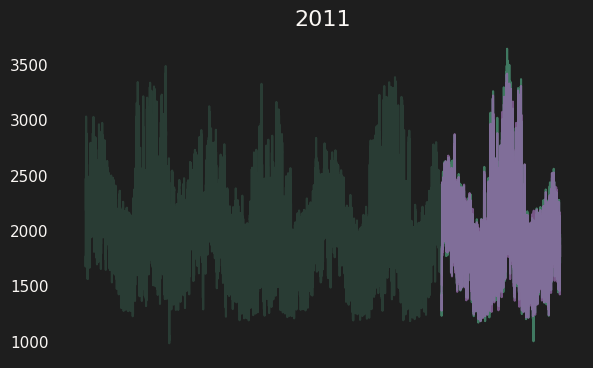

In [52]:
fig = plot_cv_results(x_train, y_train, x_valid, y_valid, y_valid_pred, region)

## Explainability

In [53]:
from visualization import plot_feature_importance

In [54]:
plot_feature_importance(reg)

alt.Chart(...)